In [88]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from urllib.parse import quote_plus

In [89]:
# Load environment variables from .env
load_dotenv()

True

In [90]:
# Fetch database credentials from .env
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# Encode the password to handle special characters
password_encoded = quote_plus(DB_PASSWORD)

# Use only this connection string (DO NOT create another one)
connection_url = f'postgresql://{DB_USER}:{password_encoded}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Use this engine throughout the script
engine = create_engine(connection_url)

In [91]:
# Establish a connection using psycopg2
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)
cursor = conn.cursor()

print("Connection to PostgreSQL successful!")

Connection to PostgreSQL successful!


In [92]:
# Define table structure for 'processed_data.csv'
create_table_query = """
CREATE TABLE IF NOT EXISTS processed_churn_data (
    Customer_ID VARCHAR(50),
    Product_ID VARCHAR(50),
    Transaction_ID VARCHAR(50),
    Purchase_Frequency INT,
    Average_Order_Value FLOAT,
    Most_Frequent_Category VARCHAR(50),
    Time_Between_Purchases INT,
    Region VARCHAR(50),
    Churn_Probability FLOAT,
    Lifetime_Value FLOAT,
    avg_order_value_standardized FLOAT,
    time_between_standardized FLOAT,
    customer_tenure_standardized FLOAT,
    recency_standardized FLOAT,
    engagement_score_standardized FLOAT,
    engagement_score_log FLOAT,
    customer_tenure_group VARCHAR(20),
    engagement_category VARCHAR(20),
    recently_active VARCHAR(10),
    engagement_score_ma3 FLOAT
);
"""

cursor.execute(create_table_query)
conn.commit()
print("Table created successfully!")

Table created successfully!


In [93]:
# Load 'processed_data.csv'
df = pd.read_csv("../data/processed_data.csv")

In [94]:
# Insert data into PostgreSQL (using the correct engine)
df.to_sql("processed_churn_data", engine, if_exists="replace", index=False)

print("Data Loaded Successfully into PostgreSQL")

Data Loaded Successfully into PostgreSQL


In [95]:
# Create a copy of the DataFrame
df_copy = df.copy()

In [96]:
# Checking for missing values
df_copy.isnull().sum()

Customer_ID                      0
Product_ID                       0
Transaction_ID                   0
Purchase_Frequency               0
Average_Order_Value              0
Most_Frequent_Category           0
Time_Between_Purchases           0
Region                           0
Churn_Probability                0
Lifetime_Value                   0
Launch_Date                      0
Peak_Sales_Date                  0
Season                           0
Preferred_Purchase_Times         0
Retention_Strategy               0
launch_year                      0
launch_month                     0
customer_tenure                  0
recency                          0
engagement_score                 0
purchase_freq_scaled             0
avg_order_value_scaled           0
time_between_scaled              0
customer_tenure_scaled           0
recency_scaled                   0
engagement_score_scaled          0
purchase_freq_standardized       0
avg_order_value_standardized     0
time_between_standar

In [97]:
# Validating the query to confirm the transformations

# Connecting using SQLAlchemy
conn = engine.connect()

# Executing the SQL query and store results in a Dataframe
query = """
SELECT customer_tenure_group, COUNT(*) 
FROM processed_churn_data
GROUP BY customer_tenure_group;
"""

df_tenure = pd.read_sql(query, conn)

# Display results
print(df_tenure)

  customer_tenure_group  count
0                   New      7
1                Medium   6709
2                 Loyal   3284


From the above output it shows that:
New customers: 7
Loyal customers: 3,284
Medium-tenure customers: 6,709

This will used to understand the customer retention patterns

In [98]:
# Checking churn rate per tenure group
query = """
SELECT customer_tenure_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY customer_tenure_group
ORDER BY churn_rate DESC; 
"""

df_churn_rate = pd.read_sql(query, conn)

print(df_churn_rate)

  customer_tenure_group  total_customers  churned_customers  churn_rate
0                   New                7                  4       57.14
1                Medium             6709               3308       49.31
2                 Loyal             3284               1619       49.30


Observations:
- New customers have the highest churn rate of 57.14%
- Medium and Loyal customers have nearly the same churn rate of 49%

In [99]:
# Checking for the churn rate by Engagement category
query = """
SELECT engagement_category,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY engagement_category
ORDER BY churn_rate DESC;
"""

df_churn_rate = pd.read_sql(query, conn)

print(df_churn_rate)

  engagement_category  total_customers  churned_customers  churn_rate
0              Medium             3229               1613       49.95
1                High             3312               1654       49.94
2                 Low             3459               1664       48.11


Observations:
- Low customer engagement have the lowest churn rate of 48.11%  
- Medium and high customer engagement have the highest churn rate of 49%

Verifying the engagement score distribution.

In [100]:
# Checking for the engagement score distribution by category
query = """
SELECT engagement_category,
    MIN(engagement_score) AS min_score,
    MAX(engagement_score) AS max_score,
    AVG(engagement_score) AS avg_score,
    COUNT(*) AS total_customers
FROM processed_churn_data
GROUP BY engagement_category;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

  engagement_category  min_score  max_score  avg_score  total_customers
0              Medium         13         33  21.587488             3229
1                High         34        689  90.782911             3312
2                 Low          0         12   6.303267             3459


Observations:
- Compared to the low engagement, high engagement score range is wide 34 -> 689
- So analyzing the churn rate at different raw engagement score levels

In [101]:
# Checking for the churn rate by raw engagement score
query = """
SELECT 
    ROUND(engagement_score, -1) AS engagement_score_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY engagement_score_group
ORDER BY engagement_score_group;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

    engagement_score_group  total_customers  churned_customers  churn_rate
0                      0.0             1189                556       46.76
1                     10.0             2700               1334       49.41
2                     20.0             1737                865       49.80
3                     30.0             1149                555       48.30
4                     40.0              762                380       49.87
..                     ...              ...                ...         ...
56                   600.0                2                  1       50.00
57                   630.0                2                  2      100.00
58                   640.0                1                  0        0.00
59                   680.0                1                  1      100.00
60                   690.0                1                  1      100.00

[61 rows x 4 columns]


Updating the Engagement Category distributions - setting better thresholds, so we can get a clearer distinction between Low, Medium, and High engagement (Check feature_engineering.sql file for the distributions made)

In [102]:
# Rerunning the Churn Rate Analysis by Engagement Category
query = """
SELECT engagement_category,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY engagement_category
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

  engagement_category  total_customers  churned_customers  churn_rate
0              Medium             3229               1613       49.95
1                High             3312               1654       49.94
2                 Low             3459               1664       48.11


Observations:
- After updating the engagement categories and rerunning the churn rate analysis, the churn rates have remained nearly the same as before.


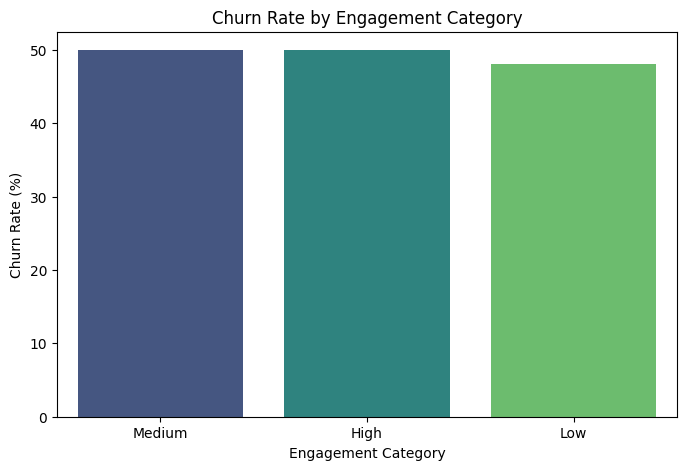

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=df_engagement_check["engagement_category"], y=df_engagement_check["churn_rate"], hue = df_engagement_check["engagement_category"], palette="viridis", legend = False)

# Labels and title
plt.xlabel("Engagement Category")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Engagement Category")

# Show the plot
plt.show()

In [104]:
# Checking the churn rate with tenure along with the customer engagement category
query = """
SELECT engagement_category, customer_tenure_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY engagement_category, customer_tenure_group
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

  engagement_category customer_tenure_group  total_customers  \
0                High                   New                2   
1              Medium                   New                3   
2                High                 Loyal             1069   
3              Medium                Medium             2193   
4                High                Medium             2241   
5              Medium                 Loyal             1033   
6                 Low                 Loyal             1182   
7                 Low                Medium             2275   
8                 Low                   New                2   

   churned_customers  churn_rate  
0                  2      100.00  
1                  2       66.67  
2                538       50.33  
3               1102       50.25  
4               1114       49.71  
5                509       49.27  
6                572       48.39  
7               1092       48.00  
8                  0        0.00  


Observations:
- New customers have extremely high churn
    - New customers + High engagement = 100% churn 
    - New customers + Medium engagement = 66.67% churn 

- Long tenure customers still have high churn 
    - High engagement + Long tenure = 50.33% churn 
    - Medium engagement + Long tenure = 49.27% churn
    - Low engagement + Long tenure = 48.39% churn

- Low engagement customers have slightly lower chaurn rates
    - Low engagement + Medium tenure = 48.00% churn

In [105]:
# Checking for the churn rate by Purchase Frequency
query = """
SELECT 
    purchase_freq_scaled,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY purchase_freq_scaled
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

    purchase_freq_scaled  total_customers  churned_customers  churn_rate
0               0.833333              524                272       51.91
1               1.000000              551                284       51.54
2               0.777778              497                254       51.11
3               0.500000              550                280       50.91
4               0.666667              535                272       50.84
5               0.555556              494                251       50.81
6               0.611111              500                254       50.80
7               0.000000              594                297       50.00
8               0.444444              532                265       49.81
9               0.888889              519                257       49.52
10              0.388889              544                269       49.45
11              0.222222              553                271       49.01
12              0.333333              505          

In [106]:
# Checking for the churn rate by Average Order Value
query = """
SELECT 
    avg_order_value_scaled,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY avg_order_value_scaled
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

      avg_order_value_scaled  total_customers  churned_customers  churn_rate
0                   0.865407                1                  1       100.0
1                   0.729091                1                  1       100.0
2                   0.153598                1                  1       100.0
3                   0.353209                1                  1       100.0
4                   0.674687                1                  1       100.0
...                      ...              ...                ...         ...
7603                0.773882                1                  0         0.0
7604                0.052515                1                  0         0.0
7605                0.999278                1                  0         0.0
7606                0.110475                2                  0         0.0
7607                0.213226                1                  0         0.0

[7608 rows x 4 columns]


In [107]:
# Checking the engagement scores for high-frequency churners
query = """
SELECT
    engagement_category,
    purchase_freq_scaled,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM processed_churn_data
GROUP BY engagement_category, purchase_freq_scaled
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

   engagement_category  purchase_freq_scaled  total_customers  \
0                 High              0.055556               12   
1                 High              0.222222               83   
2               Medium              0.666667              227   
3               Medium              0.611111              194   
4                 High              0.111111               39   
5                  Low              0.611111               82   
6               Medium              0.500000              237   
7                 High              0.833333              305   
8                 High              0.555556              164   
9               Medium              0.777778              191   
10              Medium              0.833333              165   
11                 Low              0.777778               59   
12              Medium              1.000000              158   
13                 Low              0.388889              174   
14                 Low   

Observations:
- High engagement with purchase frequency = 1.0 still has 350 customers and a churn rate of ~47.14%
- Medium engagement with purchase frequency = 0.777778 has 191 customers and a churn rate of ~48.17%
- Low engagement with purchase frequency = 0.000000 has 564 customers and a churn rate of 50.00%

In [108]:
# Checking for the churn patterns with spending behavior

query = """
WITH aov_buckets AS (
    SELECT 
        *,
        CASE 
            WHEN avg_order_value_scaled <= 0.33 THEN 'Low'
            WHEN avg_order_value_scaled <= 0.66 THEN 'Medium'
            ELSE 'High'
        END AS aov_category
    FROM processed_churn_data
)
SELECT 
    aov_category,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) AS churned_customers,
    ROUND((SUM(CASE WHEN "Churn_Probability" > 0.5 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS churn_rate
FROM aov_buckets
GROUP BY aov_category
ORDER BY churn_rate DESC;
"""

df_engagement_check = pd.read_sql(query, conn)

print(df_engagement_check)

  aov_category  total_customers  churned_customers  churn_rate
0       Medium             3296               1634       49.58
1         High             3401               1683       49.49
2          Low             3303               1614       48.86


Observations:
- Medium spenders have the highest churn rate (49.58%), followed by High spenders (49.49%), and then Low spenders (48.86%)
- Mean churn might be driven by other factors e.g., engagement, tenure, or product satisfaction